In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotnine as pn
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Previous version (only protein emb, DNA LM data and sequence features used)
- seq_feats
- lm_3utr_emb
- lm_5utr_emb
- prot_emb

In [2]:
# DNA LM embeddings
#dnalm_df = pd.read_parquet('/s/project/multispecies/fungi_code/motif_discovery_pipeline/data/embeddings_non_sac_upstream/Saccharomyces_cerevisiae_BY4741/sequence_features_and_embeddings_Saccharomyces_cerevisiae_BY4741.parquet')
dnalm_df = pd.read_parquet('data/dnalm_df.parquet')
dnalm_df.head()

,gene_id,embedding_upstream,embedding_downstream,five_prime_seq,cds,three_prime_seq,gc_5_prime,gc_3_prime,gc_cds,AAA,...,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT,species
0,YAL002W,"[0.08123832, 0.030906273, 0.014586483, -0.0152...","[-0.02917197, 0.078893326, -0.05454025, 0.1706...",TTCCAAGGCCGATGAATTCGACTCTTTCCCAGCTGCCTCTGCTGCC...,ATGGAGCAAAATGGCCTTGACCACGACAGCAGATCTAGCATCGATA...,TAACATTTCTAAATATTTAATACAACTTTGGTTACATAAAAGTAAA...,0.365902,0.310000,0.372057,0.043956,...,0.031397,0.0,0.010989,0.010989,0.009419,0.031397,0.013344,0.032967,0.032967,Saccharomyces_cerevisiae_BY4741
1,YAL003W,"[0.032580532, 0.025513712, -0.031748626, -0.04...","[-0.030835396, -0.072578646, -0.05808209, 0.14...",CTTCATGTCAGCCTGCACTTCTGGGTCGTTGAAGTTTCTACCGATC...,ATGGCATCCACCGATTTCTCCAAGATTGAAACTTTGAAACAATTAA...,TAAAAGGCTTTTTTATAAACTTTTTATAATTAACATTAAAGCAAAA...,0.372881,0.253333,0.448220,0.009709,...,0.029126,0.0,0.000000,0.014563,0.004854,0.014563,0.043689,0.038835,0.004854,Saccharomyces_cerevisiae_BY4741
2,YAL004W,"[0.07244772, -0.004530292, 0.08222245, -0.0672...","[-0.032747507, -0.1945743, -0.083140165, 0.042...",CCAATTTGTCACCAGCTTCAGAAATGGTGTTCTTCAAAGAGTAAGC...,ATGGGTGTCACCAGCGGTGGCCTTAACTTCAAAGATACCGTCTTCA...,TAAATCAATACCGACAGCTTTTGACATATTATCTGTTATTTACTTG...,0.417747,0.346667,0.451163,0.023256,...,0.018605,0.0,0.000000,0.023256,0.009302,0.000000,0.055814,0.032558,0.000000,Saccharomyces_cerevisiae_BY4741
3,YAL008W,"[0.018979808, 0.34264776, -0.0416448, 0.006748...","[0.0005224135, -0.061880764, -0.061566852, 0.1...",GTGTCCGGGCCTCGCAGGCGTTCTACTAGCAAGACATCCAGTGCGA...,ATGACTTTGGCTTTTAATATGCAACGGTTGGTGTTTCGTAATTTGA...,TGAGCAAGACAAATGACCAGATATAAACGAGGGTTATATTCTTTCG...,0.381854,0.296667,0.388889,0.045455,...,0.020202,0.0,0.000000,0.015152,0.005051,0.055556,0.025253,0.065657,0.040404,Saccharomyces_cerevisiae_BY4741
4,YAL009W,"[-0.009528967, 0.003373141, 0.000113023896, -0...","[-0.01995761, -0.24868764, -0.054501917, 0.086...",CAAGATAATGTCAAAGTTAGTGGTCGTCCTGTGTTTGTAGAATGTG...,ATGGAGCCAGAGAGCATAGGCGATGTGGGGAACCATGCCCAGGATG...,TGAAAGAGTTGGAGGGCTTCTTCCTTCGAATAAGAGGTCATATTTA...,0.368893,0.323333,0.414414,0.042471,...,0.023166,0.0,0.000000,0.023166,0.007722,0.011583,0.027027,0.019305,0.038610,Saccharomyces_cerevisiae_BY4741


In [3]:
# Sequence features
seq_feats = dnalm_df[['gene_id'] + list(dnalm_df.iloc[:, 6:-1].columns)].dropna()
seq_feats.head()

,gene_id,gc_5_prime,gc_3_prime,gc_cds,AAA,AAC,AAG,AAT,ACA,ACC,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
0,YAL002W,0.365902,0.310000,0.372057,0.043956,0.019623,0.018053,0.039246,0.013344,0.007849,...,0.006279,0.031397,0.0,0.010989,0.010989,0.009419,0.031397,0.013344,0.032967,0.032967
1,YAL003W,0.372881,0.253333,0.448220,0.009709,0.024272,0.077670,0.004854,0.000000,0.019417,...,0.000000,0.029126,0.0,0.000000,0.014563,0.004854,0.014563,0.043689,0.038835,0.004854
2,YAL004W,0.417747,0.346667,0.451163,0.023256,0.023256,0.000000,0.046512,0.004651,0.074419,...,0.000000,0.018605,0.0,0.000000,0.023256,0.009302,0.000000,0.055814,0.032558,0.000000
3,YAL008W,0.381854,0.296667,0.388889,0.045455,0.020202,0.040404,0.050505,0.015152,0.005051,...,0.000000,0.020202,0.0,0.000000,0.015152,0.005051,0.055556,0.025253,0.065657,0.040404
4,YAL009W,0.368893,0.323333,0.414414,0.042471,0.011583,0.023166,0.027027,0.011583,0.007722,...,0.003861,0.023166,0.0,0.000000,0.023166,0.007722,0.011583,0.027027,0.019305,0.038610


In [4]:
# Upstream sequence embedding
lm_5utr_emb = pd.DataFrame(np.stack(dnalm_df.dropna().embedding_upstream.values), index=dnalm_df.dropna().gene_id)
lm_5utr_emb.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
gene_id,,,,,,,,,,,,,,,,,,,,,
YAL002W,0.081238,0.030906,0.014586,-0.015279,0.028113,0.121253,0.068083,0.171768,-0.014086,0.544913,...,-0.030622,-0.045234,-0.263034,0.105608,0.000841,-0.068895,0.092609,0.012248,0.040396,-0.008431
YAL003W,0.032581,0.025514,-0.031749,-0.042321,-0.052058,0.100852,-0.040193,0.227620,-0.041441,0.127843,...,-0.004374,-0.035856,-0.159351,0.127666,0.066430,-0.019931,0.045678,0.022475,-0.025326,-0.090283
YAL004W,0.072448,-0.004530,0.082222,-0.067203,-0.010486,-0.015001,0.229780,0.198991,-0.101902,0.422294,...,-0.029051,-0.134829,-0.129500,0.040292,0.037237,0.001085,0.122111,0.084727,0.389339,0.085969
YAL008W,0.018980,0.342648,-0.041645,0.006749,-0.031477,0.081134,0.195077,0.200070,-0.049627,0.392190,...,0.044176,-0.022111,-0.216389,0.075199,0.044513,-0.020134,0.051188,0.055149,-0.255109,-0.061252
YAL009W,-0.009529,0.003373,0.000113,-0.007516,-0.010976,0.063841,0.181502,0.260650,-0.035609,0.194044,...,-0.007081,0.005693,-0.196746,0.071950,0.073255,0.002211,0.107910,-0.004822,-0.406600,-0.065601


In [5]:
# Downstream sequence embedding
lm_3utr_emb = pd.DataFrame(np.stack(dnalm_df.dropna().embedding_downstream.values), index=dnalm_df.dropna().gene_id)
lm_3utr_emb.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
gene_id,,,,,,,,,,,,,,,,,,,,,
YAL002W,-0.029172,0.078893,-0.054540,0.170680,-0.107067,-0.092142,0.094663,-0.073110,0.010419,0.073653,...,0.078681,0.033648,0.014682,-0.074566,0.052284,0.034215,0.132639,0.110446,-0.013290,0.052378
YAL003W,-0.030835,-0.072579,-0.058082,0.145516,0.149264,-0.134691,0.159887,-0.117146,0.021611,0.060180,...,0.033926,0.019848,-0.004159,-0.071930,0.093962,-0.118783,0.159958,0.053212,-0.016180,-0.016293
YAL004W,-0.032748,-0.194574,-0.083140,0.042409,-0.167408,-0.126880,0.001361,-0.057888,0.031826,0.058797,...,0.064126,0.029112,-0.026013,-0.039213,0.102791,-0.111031,0.153221,0.017565,0.043769,0.003665
YAL008W,0.000522,-0.061881,-0.061567,0.106177,0.190146,-0.093892,0.050411,-0.155466,-0.009316,-0.006226,...,0.088757,0.043351,-0.037464,-0.073037,0.038244,-0.024653,-0.003237,0.044000,0.024346,0.006319
YAL009W,-0.019958,-0.248688,-0.054502,0.086972,0.208853,0.028963,-0.019007,-0.138868,-0.011246,0.009775,...,0.073859,0.001456,-0.025106,-0.022704,0.054237,-0.049160,-0.003523,0.056109,-0.006815,0.032631


In [6]:
# Protein embeddings from ESM2
#dataset = pd.read_pickle("/s/project/semi_supervised_multispecies/Downstream/Sequences/Annotation/Sequences/saccharomyces_cerevisiae/all_w_protein_seqs_embs.pickle")
#prot_emb = pd.DataFrame(np.stack(dataset.protein_emb.dropna().values), index=dataset.gene_id)
prot_emb = pd.read_parquet('data/protein_emb.parquet')
prot_emb.head()

,0,1,2,3,4,5,6,7,8,9,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
gene_id,,,,,,,,,,,,,,,,,,,,,
YAL037W,0.077271,-0.057495,0.052307,0.074829,0.021423,-0.085205,0.071228,0.095398,0.028702,0.050751,...,0.134277,0.072266,-0.021713,0.066406,0.005680,0.021194,0.082520,-0.128540,-0.082214,-0.041718
YAL016W,0.064758,0.026871,-0.037994,0.045532,-0.023880,-0.051514,0.044617,-0.152832,0.023239,0.023300,...,0.158203,0.056488,-0.054749,0.015411,-0.078064,0.029373,0.055328,-0.112305,-0.038544,0.107849
YAL003W,0.074219,-0.017822,-0.073120,0.050598,0.026871,0.065979,0.068481,-0.242920,0.031342,0.042450,...,0.030151,-0.015701,-0.027069,0.044128,-0.043304,-0.096680,-0.028107,-0.229614,-0.015327,0.076904
YAL053W,-0.002195,-0.014854,-0.033875,0.077026,-0.005131,-0.097351,0.085815,-0.107666,-0.033203,0.048950,...,0.139893,0.009560,-0.075989,0.025589,-0.024933,-0.044464,0.020859,-0.033234,-0.054749,0.038361
YAL031W-A,0.049866,0.035248,0.141846,0.016281,-0.022156,-0.022507,-0.046112,0.180176,0.170898,0.080444,...,0.090759,0.108032,-0.091125,0.139648,-0.069824,0.188232,0.010498,0.062744,-0.078430,0.033264


In [7]:
def zscore_matrix(mat):
    m = np.mean(np.array(mat, dtype=np.float32).flatten())
    sd = np.std(np.array(mat, dtype=np.float32).flatten())

    mat_z = (mat - m)/sd
    return mat_z

In [8]:
%%time

seq_feats = seq_feats.set_index('gene_id')
# seq_feats_z = zscore_matrix(seq_feats)
# seq_feats_z = seq_feats_z.reset_index()

prot_emb_z = zscore_matrix(prot_emb)
prot_emb_z.columns = prot_emb_z.columns.astype(str)
prot_emb_z.columns = 'ESM2_' + prot_emb_z.columns
prot_emb_z = prot_emb_z.reset_index()

lm_3utr_emb_z = zscore_matrix(lm_3utr_emb)
lm_3utr_emb_z.columns = lm_3utr_emb_z.columns.astype(str)
lm_3utr_emb_z.columns = 'LM_3UTR_' + lm_3utr_emb_z.columns
lm_3utr_emb_z = lm_3utr_emb_z.reset_index()

lm_5utr_emb_z = zscore_matrix(lm_5utr_emb)
lm_5utr_emb_z.columns = lm_5utr_emb_z.columns.astype(str)
lm_5utr_emb_z.columns = 'LM_5UTR_' + lm_5utr_emb_z.columns
lm_5utr_emb_z = lm_5utr_emb_z.reset_index()

# Merge all the embeddings to get a per gene S.cerevisiae embedding
yeast_emb_full = seq_feats.merge(prot_emb_z, on='gene_id').merge(lm_3utr_emb_z, on='gene_id').merge(lm_5utr_emb_z, on='gene_id')
yeast_emb_full

CPU times: user 572 ms, sys: 187 ms, total: 759 ms
Wall time: 839 ms


,gene_id,gc_5_prime,gc_3_prime,gc_cds,AAA,AAC,AAG,AAT,ACA,ACC,...,LM_5UTR_758,LM_5UTR_759,LM_5UTR_760,LM_5UTR_761,LM_5UTR_762,LM_5UTR_763,LM_5UTR_764,LM_5UTR_765,LM_5UTR_766,LM_5UTR_767
0,YAL002W,0.365902,0.310000,0.372057,0.043956,0.019623,0.018053,0.039246,0.013344,0.007849,...,-0.078495,-0.101951,-0.451596,0.140201,-0.027987,-0.139936,0.119334,-0.009675,0.035513,-0.042870
1,YAL003W,0.372881,0.253333,0.448220,0.009709,0.024272,0.077670,0.004854,0.000000,0.019417,...,-0.036358,-0.086898,-0.285149,0.175611,0.077306,-0.061331,0.043992,0.006744,-0.069993,-0.174272
2,YAL004W,0.417747,0.346667,0.451163,0.023256,0.023256,0.000000,0.046512,0.004651,0.074419,...,-0.075972,-0.245783,-0.237227,0.035347,0.030442,-0.027595,0.166694,0.106680,0.595686,0.108673
3,YAL008W,0.381854,0.296667,0.388889,0.045455,0.020202,0.040404,0.050505,0.015152,0.005051,...,0.041582,-0.064832,-0.376715,0.091384,0.042122,-0.061658,0.052838,0.059197,-0.438873,-0.127666
4,YAL009W,0.368893,0.323333,0.414414,0.042471,0.011583,0.023166,0.027027,0.011583,0.007722,...,-0.040703,-0.020197,-0.345180,0.086169,0.088264,-0.025787,0.143896,-0.037077,-0.682068,-0.134648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6574,YPR195C,0.334995,0.393333,0.467890,0.027523,0.000000,0.000000,0.027523,0.045872,0.009174,...,-0.069516,-0.091421,-0.402476,0.095457,0.023955,-0.072979,-0.082304,0.072628,-0.665834,0.037950
6575,YPR197C,0.376869,0.276667,0.374332,0.058824,0.021390,0.021390,0.016043,0.042781,0.005348,...,-0.014195,-0.102008,-0.424302,0.133435,0.087042,-0.024667,0.205772,0.009731,-0.687237,0.048592
6576,YPR199C,0.329013,0.283333,0.391156,0.030612,0.020408,0.047619,0.047619,0.027211,0.003401,...,0.052901,-0.037409,-0.385326,0.083647,0.060815,-0.034371,0.054171,0.069161,-0.484573,-0.094109
6577,YPR200C,0.366899,0.313333,0.376923,0.038462,0.015385,0.038462,0.023077,0.030769,0.015385,...,0.087128,-0.082817,-0.418286,0.099563,0.080339,-0.000032,0.105696,0.047736,-0.490977,0.055293


# Load the data, that is needed to be incorporated as well
- experimental gene-gene interaction by Costazo et al 2016 
- gene expression and fitness data
- Yeast Net

In [9]:
# Yeast Net data
YeastNetdata = pd.read_csv('data/YeastNet.csv', sep = ',', index_col = 0)

In [10]:
node_count = len(np.unique(np.concatenate([YeastNetdata.gene1, YeastNetdata.gene2])))
print(f"{len(YeastNetdata)/(node_count**2) * 100} % edges")

0.7386006109725306 % edges


In [11]:
YeastNetdata.to_csv("data/YeastNet.edg", sep="\t", columns=["gene1", "gene2", "edge_value"], header=False, index=False)


In [12]:
!pecanpy --input "data/YeastNet.edg" --output "data/YeastNetEmbeddings.npz" --mode SparseOTF --weighted


/Users/lukasveskrna/Developer/Notebooks/yeast-embeddings/venv/lib/python3.12/site-packages/pecanpy/cli.py:302: UserWarning: When p = 1 and q = 1, it is highly recommended to use PreCompFirstOrder over SparseOTF (current selection). The runtime could be improved greatly with low memory usage.
  check_mode(g, args)
Took 00:00:01.28 to load Graph
Took 00:00:00.00 to pre-compute transition probabilities
Took 00:00:13.32 to generate walks
Took 00:00:14.70 to train embeddings


In [13]:
yeastnet_embeddings_npz = np.load("data/YeastNetEmbeddings.npz")
yeastnet_embeddings = pd.DataFrame(np.stack(yeastnet_embeddings_npz["data"]), index=yeastnet_embeddings_npz["IDs"]).add_prefix("yeastnet_")
yeastnet_embeddings

yeastnet_emb_z = zscore_matrix(yeastnet_embeddings)
yeastnet_emb_z.columns = yeastnet_emb_z.columns.astype(str)
yeastnet_emb_z = yeastnet_emb_z.reset_index()
yeastnet_emb_z.rename(columns={'index':'gene_id'}, inplace=True)

# m = np.mean(np.array(yeastnet_emb_z.iloc[:,1:], dtype=np.float32).flatten())
# sd = np.std(np.array(yeastnet_emb_z.iloc[:,1:], dtype=np.float32).flatten())
# print(m, sd)

yeastnet_emb_z

,gene_id,yeastnet_0,yeastnet_1,yeastnet_2,yeastnet_3,yeastnet_4,yeastnet_5,yeastnet_6,yeastnet_7,yeastnet_8,...,yeastnet_118,yeastnet_119,yeastnet_120,yeastnet_121,yeastnet_122,yeastnet_123,yeastnet_124,yeastnet_125,yeastnet_126,yeastnet_127
0,YBR247C,-0.352433,-0.938874,-1.597711,-0.121859,-0.362443,-0.074111,0.992338,-1.230891,1.034313,...,-0.753694,0.274636,-1.060315,-0.990875,-1.043207,-0.248770,-0.621239,-1.418047,0.181001,0.249858
1,YDL060W,-0.735854,-0.163183,-1.812929,-0.344428,0.301855,0.131564,0.432978,-1.237034,0.658309,...,-1.230858,-0.096112,-0.754903,-1.075234,-1.424513,0.177388,0.056827,-1.694650,0.632356,0.224426
2,YBL039C,-0.780921,-0.042540,-1.522770,-0.476517,-0.037134,-0.238042,0.360130,-1.492630,-0.025770,...,-1.357694,-0.298996,-1.533638,-0.966837,-0.696036,-0.519429,-0.282910,-0.876952,0.532264,0.275805
3,YAL059W,-0.732974,-1.057212,-0.983247,-0.052518,0.284285,-0.081706,0.901189,-1.488624,0.587023,...,-1.544271,0.490778,-1.156849,-0.865543,0.120035,-0.034487,-0.454737,-2.035937,-0.336599,0.043045
4,YCR057C,-0.398507,-0.137580,-1.260953,-0.355681,-0.762096,0.071170,0.762892,-1.174055,0.523187,...,-0.366386,0.330511,-0.451025,-0.847573,-1.412488,0.086283,-0.329909,-1.669357,0.163515,0.383996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5725,YOR293C-A,-0.501814,0.915966,-0.526349,-0.906129,-0.930171,-0.138589,0.475458,-0.177606,-0.278709,...,-0.040850,0.647110,-0.664326,0.350374,0.046522,0.428568,0.126900,0.210590,0.215877,-0.102688
5726,YOR080W,-0.208805,0.277573,-0.902432,-0.553037,-0.150594,-0.448652,0.441597,0.408696,0.602367,...,0.034519,0.281089,-0.738417,0.129442,0.537906,0.430593,-0.513862,-0.629458,0.305022,-0.767325
5727,YBR058C-A,-0.254077,0.505142,-0.305762,-0.753277,-0.799466,-0.305362,-0.045847,0.524775,-0.326786,...,0.357024,0.957303,-0.314468,0.353312,0.501001,0.574139,-0.312177,-0.042107,0.284858,-0.619235
5728,YCR039C,-0.154973,0.476902,-0.308516,-0.674132,-0.554921,-0.292799,-0.036700,0.248752,0.044755,...,-0.179826,0.856139,-0.629636,0.298369,0.079472,0.303069,-0.188356,-0.190227,0.504812,-0.417949


In [14]:
# Gene expression and fitness data
data_experiment_decriptions= pd.read_csv('Data/yp_screens_haphom_20221025.txt', sep = '\t', index_col = 0)
data_Turco = pd.read_csv('Data/yp_matrix_z_haphom_20221025.txt', sep = '\t', index_col = 0)
data_Turco.index.name = "gene_id"  

In [15]:
data_experiment_decriptions

,name,collection,phenotype,conditionset,medium,paper,pmid,latest_tested_status,num_tested
id,,,,,,,,,
1,hap a | growth (streaks on agar) | rapamycin [...,hap a,growth (streaks on agar),rapamycin [25 nM],YPD,"Chan TF~Zheng XF, 2000 - 11078525",11078525,request abandoned,2216
2,hap a | NHEJ | standard | SC - Ura | Ooi SL~Bo...,hap a,NHEJ,standard,SC - Ura,"Ooi SL~Boeke JD, 2001 - 11701889",11701889,request abandoned,4647
4,hap alpha | growth (exponential growth rate) |...,hap alpha,growth (exponential growth rate),ethanol [8%],YPD,"Yoshikawa K~Shimizu H, 2009 - 19054128",19054128,loaded,4729
5,hap alpha | growth (exponential growth rate) |...,hap alpha,growth (exponential growth rate),sodium chloride [1 M],YPD,"Yoshikawa K~Shimizu H, 2009 - 19054128",19054128,loaded,4729
7,hap a | growth (colony size) | streptomycin [4...,hap a,growth (colony size),streptomycin [40 mg/ml],SC,"Alamgir M~Golshani A, 2010 - 20691087",20691087,loaded,4669
...,...,...,...,...,...,...,...,...,...
22217,"hom | growth (pooled culture, barseq) | gadoli...",hom,"growth (pooled culture, barseq)","gadolinium [IC20], time [15 gen]",YPD,"Pallares RM~Abergel RJ, 2022 - 35040455",35040455,loaded,4291
22218,hap a | protein transport to the vacuole (Sec6...,hap a,protein transport to the vacuole (Sec61-mCherr...,rapamycin [200 ug/L],SC - Leu,"Chen S~Ferro-Novick S, 2020 - 32690699",32690699,request abandoned,0
22219,hap a | mating creep | opposite mating type st...,hap a,mating creep,opposite mating type strain [MAT alpha (BY4742)],YPD,"Arras SDM~Ganley ARD, 2022 - 35298616",35298616,loaded,4929


In [16]:
data_Turco


,1,2,4,5,7,8,9,10,11,14,...,22212,22213,22214,22215,22216,22217,22218,22219,22220,22228
gene_id,,,,,,,,,,,,,,,,,,,,,
YAL002W,-0.071896,0.0,-0.351851,-0.272362,0.021981,-0.672391,-0.243525,-0.291566,-2.623798,1.015551,...,0.013849,-0.089649,-0.030395,-0.059043,-0.006962,-0.078004,-8.335666,0.0,NaN,-1.692692
YAL005C,-0.071896,0.0,-0.539305,-0.282393,-0.237616,-0.290585,-0.134638,0.249022,NaN,-0.984568,...,0.013849,-0.089649,-0.030395,-0.059043,-0.006962,-0.078004,0.000000,0.0,NaN,-2.003358
YAL007C,-0.071896,0.0,-0.316477,-1.716964,0.669387,0.352375,0.557858,0.136025,1.104770,-0.291439,...,0.013849,-0.089649,-0.030395,-0.059043,-0.006962,-0.078004,0.000000,0.0,NaN,-1.374965
YAL008W,-0.071896,0.0,-0.247000,-0.095510,1.414719,0.122065,-0.573721,-1.002780,0.211580,0.262476,...,0.013849,-0.089649,-0.030395,-0.059043,-0.006962,-8.079187,0.000000,0.0,NaN,0.640416
YAL009W,-4.817055,0.0,-2.212226,-1.010491,-0.250085,-0.016314,-0.030528,-0.013983,0.233321,NaN,...,0.013849,-0.089649,-0.030395,-0.059043,-0.006962,-0.078004,0.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YPR196W,-0.071896,0.0,-0.320923,-0.872477,1.552995,-0.010449,-0.140292,-1.044475,-0.102829,-0.233030,...,0.013849,-0.089649,-0.030395,-0.059043,-0.006962,-0.078004,0.000000,0.0,-1.337041,-0.130582
YPR198W,-0.071896,0.0,-0.705077,-0.958221,0.799231,0.193457,0.143067,1.181440,0.186180,-0.443869,...,0.013849,-0.089649,-0.030395,-0.059043,-0.006962,-0.078004,0.000000,0.0,-0.492903,-1.622164
YPR199C,-0.071896,0.0,-0.228440,-0.432992,0.423262,-0.940111,3.520616,0.321456,-0.192618,-0.308187,...,0.013849,-0.089649,-0.030395,-0.059043,-0.006962,-0.078004,0.000000,0.0,-0.047430,1.573639


In [17]:
# filter for gene expression data from experiment_descriptions
gene_expressions = data_experiment_decriptions[data_experiment_decriptions["phenotype"].str.contains("expression of", na=False)]
expression_ids = gene_expressions.index.astype(str)

print(len(expression_ids))

# access the gene expression columns in data_Turco
data_Turco_gene_expressions = data_Turco[expression_ids]
data_Turco_gene_expressions

6130


,14,575,576,5658,5659,5660,5661,5662,5663,5664,...,16249,16250,16445,16683,16684,16685,16692,21877,21888,21932
gene_id,,,,,,,,,,,,,,,,,,,,,
YAL002W,1.015551,0.0,0.0,0.166776,0.593701,0.881766,-1.825381,-4.183916,-2.297258,3.148642,...,0.039332,0.039744,-2.121822,-1.766094,-1.222334,-0.899787,0.0,0.0,0.718919,1.315787
YAL005C,-0.984568,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.039332,0.039744,NaN,0.198761,-0.359510,-0.518293,0.0,0.0,-1.741585,0.268343
YAL007C,-0.291439,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.039332,0.039744,-2.363746,0.711531,0.071902,0.244696,0.0,0.0,NaN,NaN
YAL008W,0.262476,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.039332,0.039744,-2.827468,0.936046,0.934726,1.961420,0.0,0.0,0.495987,0.889903
YAL009W,NaN,0.0,0.0,0.222402,0.813596,0.150954,-0.021129,-1.063710,-0.019370,-0.502173,...,-3.854544,0.039744,1.223983,NaN,NaN,NaN,0.0,0.0,0.198745,-0.307176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YPR196W,-0.233030,0.0,0.0,-0.054603,-0.431040,-0.604339,-0.752402,-0.100895,0.211024,0.431753,...,0.039332,0.039744,0.310691,0.447998,0.287608,1.007684,0.0,0.0,-0.858116,-0.560404
YPR198W,-0.443869,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.039332,0.039744,NaN,-0.339980,0.503314,0.053949,0.0,0.0,-1.254438,-0.146031
YPR199C,-0.308187,0.0,0.0,0.331140,0.284583,0.038758,-0.752012,-0.173785,0.372366,0.625433,...,0.039332,0.039744,-0.932724,1.014407,0.503314,0.435443,0.0,0.0,-0.734265,-0.445300


In [18]:
# Fixing data_Turco_gene expressions

# removes columns with around over > 20% NaN values
data_Turco_gene_expressions = data_Turco_gene_expressions.loc[:, data_Turco_gene_expressions.isna().sum() <= 1200]

# Fill remaining NaN values with the mean of the column
data_Turco_gene_expressions = data_Turco_gene_expressions.fillna(data_Turco_gene_expressions.mean())

# remove the columns that are filled with > 20% zeros
data_Turco_gene_expressions = data_Turco_gene_expressions.loc[:, (data_Turco_gene_expressions == 0).sum() <= 1200]

data_Turco_gene_expressions

,14,11807,11808,16247,16248,16249,16250,16683,16684,16685,21888,21932
gene_id,,,,,,,,,,,,
YAL002W,1.015551,1.972265,-1.441269,0.032064,0.032865,0.039332,0.039744,-1.766094,-1.222334,-0.899787,0.718919,1.315787
YAL005C,-0.984568,-0.612589,0.479318,0.032064,0.032865,0.039332,0.039744,0.198761,-0.359510,-0.518293,-1.741585,0.268343
YAL007C,-0.291439,1.655540,0.022315,0.032064,0.032865,0.039332,0.039744,0.711531,0.071902,0.244696,-0.342359,0.223590
YAL008W,0.262476,0.244914,0.107434,0.032064,0.032865,0.039332,0.039744,0.936046,0.934726,1.961420,0.495987,0.889903
YAL009W,-0.279760,0.274440,0.110464,0.032064,0.032865,-3.854544,0.039744,-0.047052,-0.069950,-0.013320,0.198745,-0.307176
...,...,...,...,...,...,...,...,...,...,...,...,...
YPR196W,-0.233030,-1.095670,-0.241713,0.032064,0.032865,0.039332,0.039744,0.447998,0.287608,1.007684,-0.858116,-0.560404
YPR198W,-0.443869,-0.959960,-0.095216,3.206382,0.032865,0.039332,0.039744,-0.339980,0.503314,0.053949,-1.254438,-0.146031
YPR199C,-0.308187,-0.116135,-0.086297,0.032064,0.032865,0.039332,0.039744,1.014407,0.503314,0.435443,-0.734265,-0.445300


In [19]:
# add data Turco gene expressions
data_Turco_gene_expressions_z = zscore_matrix(data_Turco_gene_expressions)
data_Turco_gene_expressions_z.columns = data_Turco_gene_expressions_z.columns.astype(str)
data_Turco_gene_expressions_z.columns = 'data_Turco_expression' + data_Turco_gene_expressions_z.columns
data_Turco_gene_expressions_z = data_Turco_gene_expressions_z.reset_index()

data_Turco_gene_expressions_z

,gene_id,data_Turco_expression14,data_Turco_expression11807,data_Turco_expression11808,data_Turco_expression16247,data_Turco_expression16248,data_Turco_expression16249,data_Turco_expression16250,data_Turco_expression16683,data_Turco_expression16684,data_Turco_expression16685,data_Turco_expression21888,data_Turco_expression21932
0,YAL002W,1.171484,2.194265,-1.454995,0.120081,0.120937,0.127851,0.128291,-1.802252,-1.220942,-0.876121,0.854368,1.492454
1,YAL005C,-0.966756,-0.569090,0.598221,0.120081,0.120937,0.127851,0.128291,0.298290,-0.298534,-0.468282,-1.776051,0.372677
2,YAL007C,-0.225762,1.855669,0.109659,0.120081,0.120937,0.127851,0.128291,0.846470,0.162670,0.347396,-0.280199,0.324833
3,YAL008W,0.366405,0.347630,0.200656,0.120081,0.120937,0.127851,0.128291,1.086489,1.085078,2.182672,0.616041,1.037160
4,YAL009W,-0.213276,0.379195,0.203895,0.120081,0.120937,-4.034924,0.128291,0.035502,0.011022,0.071563,0.298273,-0.242586
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4549,YPR196W,-0.163319,-1.085530,-0.172602,0.120081,0.120937,0.127851,0.128291,0.564738,0.393272,1.163074,-0.831572,-0.513301
4550,YPR198W,-0.388719,-0.940449,-0.015988,3.513607,0.120937,0.127851,0.128291,-0.277655,0.623874,0.143477,-1.255263,-0.070312
4551,YPR199C,-0.243666,-0.038352,-0.006454,0.120081,0.120937,0.127851,0.128291,1.170261,0.623874,0.551316,-0.699168,-0.390249
4552,YPR200C,-0.420003,0.080824,0.291845,0.120081,0.120937,0.127851,0.128291,0.625506,0.162670,0.755235,-1.114033,-0.734796


In [20]:
# Add yeast yeastnet data to the model
yeast_emb_full = yeast_emb_full.merge(yeastnet_emb_z, on="gene_id")

# Add data Turco gene expressions to the predictive model
yeast_emb_full = yeast_emb_full.merge(data_Turco_gene_expressions_z, on="gene_id")


0.8952467315349779


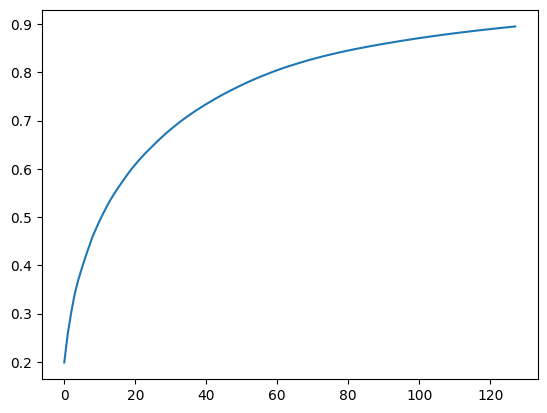

In [21]:
# Check what is the percentage of the variance explained by compressed data compared to the full data
N=128
pca = PCA(n_components=N)
pca.fit_transform(yeast_emb_full.iloc[:,1:])
ev = pca.explained_variance_ratio_.cumsum()
print(ev[-1])
plt.plot(range(0, N), ev)

In [22]:
dims = 128
emb_full_pca = pd.DataFrame(PCA(n_components=dims).fit_transform(yeast_emb_full.iloc[:,1:]), index=yeast_emb_full.gene_id).reset_index()
emb_full_pca

,gene_id,0,1,2,3,4,5,6,7,8,...,118,119,120,121,122,123,124,125,126,127
0,YAL002W,-1.373425,-3.742327,-1.087590,-1.006048,0.733800,-0.827896,-2.815090,0.743181,0.084964,...,0.047238,-0.066354,-0.230488,-0.056226,0.377320,-0.064057,0.100363,-0.062131,0.499762,0.341775
1,YAL008W,-1.293139,-4.549437,1.968872,-5.756501,-0.921201,-1.026339,-2.795745,-0.678418,-0.218367,...,0.041535,-0.269937,-0.157948,0.008875,-0.103699,-0.884339,-0.012747,-0.302016,-0.080290,-0.121853
2,YAL009W,-1.856676,1.545923,-3.112089,-2.963667,-1.854354,1.503579,0.710920,2.460025,-2.109061,...,-0.358058,-0.297920,-0.217740,-0.370203,-0.424031,-0.202697,0.038593,-0.249108,0.583943,0.496549
3,YAL011W,-8.154035,1.887591,-0.360688,-2.798492,2.700294,-0.684676,-0.601591,1.094966,0.651903,...,0.088954,0.458580,-0.060286,-0.522345,-0.654354,-0.047073,-0.292605,-0.498490,-0.149957,0.173066
4,YAL012W,15.394169,1.572410,2.604940,2.502846,0.412707,-0.485937,2.472947,3.338986,1.485192,...,0.520097,0.509252,0.786292,-0.140947,-0.769195,-0.221711,0.246151,0.239869,0.417006,0.716449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4432,YPR188C,-0.080103,0.172528,-3.487257,-3.609617,-2.606398,4.398767,-1.410951,0.592339,-0.939253,...,0.106220,-0.107941,-0.217047,0.399567,0.258392,0.192098,0.298522,-0.235657,-0.581777,-0.524244
4433,YPR193C,7.948860,-5.819867,0.253285,-0.383691,-1.430942,0.106014,0.167620,-0.074798,1.535178,...,-0.828510,-0.267623,-0.476180,0.183887,-0.736658,0.612410,-0.270449,0.465751,-0.056343,0.391369
4434,YPR194C,6.310723,-1.131749,-0.268725,4.250781,1.748463,-0.226740,-1.523751,-1.732121,-4.342296,...,-0.237604,-0.258768,-0.119190,0.514633,0.263490,-0.219346,-0.132357,0.167183,-0.415340,0.010064
4435,YPR199C,-6.906783,-2.794871,-0.369618,0.966810,0.459401,0.096908,-1.586435,-1.214948,-0.029486,...,-0.139026,-0.238051,-0.569939,0.033536,-0.334097,-0.079610,-0.589716,-0.862972,0.245071,-0.498692


In [23]:
# Gene-gene interactions, they need to be combined, cause separatedly for essential and non-essential genes
GxG_data_Costanzo_ExE = pd.read_csv('data/SGA_ExE_clustered.cdt', sep = '\t', dtype = 'str')
GxG_data_Costanzo_ExN = pd.read_csv('data/SGA_ExN_clustered.cdt', sep = '\t', dtype = 'str')
GxG_data_Costanzo_NxN = pd.read_csv('data/SGA_NxN_clustered.cdt', sep = '\t', dtype = 'str')

In [24]:
def cdt_to_mat(cdt):
    mat = cdt.iloc[5:, 6:].astype(np.float64)
    mat.columns = cdt.iloc[1, 6:]
    return mat.set_index(cdt["ORF"].iloc[5:])

ExE = cdt_to_mat(GxG_data_Costanzo_ExE)
ExN = cdt_to_mat(GxG_data_Costanzo_ExN)
NxN = cdt_to_mat(GxG_data_Costanzo_NxN)

In [25]:
all_genes = sorted(set(ExE.index).union(ExE.columns).union(ExN.index).union(ExN.columns).union(NxN.index).union(NxN.columns))
ExE_ = ExE.loc[~ExE.index.duplicated(),~ExE.columns.duplicated()].reindex(index=all_genes, columns=all_genes)
ExN_ = ExN.loc[~ExN.index.duplicated(),~ExN.columns.duplicated()].reindex(index=all_genes, columns=all_genes)
NxN_ = NxN.loc[~NxN.index.duplicated(),~NxN.columns.duplicated()].reindex(index=all_genes, columns=all_genes)

In [26]:
GxG = ExE_.fillna(0) + ExN_.fillna(0) + NxN_.fillna(0)
GxG[(ExE_.isna() & ExN_.isna() & NxN_.isna())] = np.nan

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def eval_with_Costanzo_GxG(emb, reduced_count=10_000, test_size=0.1, random_state=42):
    data = GxG.stack(future_stack=True).dropna()
    if reduced_count is not None:
        data = data[:reduced_count]
        
    gene_pairs = data.index.to_frame().reset_index(drop=True)
    gene_pairs.columns = ["gene1", "gene2"]
    gene_pairs = gene_pairs.assign(interaction=pd.Series(np.array(data)))
    
    gene_pairs_emb = gene_pairs.merge(emb, left_on="gene1", right_on="gene_id").merge(emb, left_on="gene2", right_on="gene_id").drop(["gene1", "gene2", "gene_id_x", "gene_id_y"], axis=1)
    y = gene_pairs_emb.interaction
    X = gene_pairs_emb.drop(["interaction"], axis=1)
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    reg = LinearRegression()
    reg.fit(train_X, train_y)

    pred_y = reg.predict(test_X)
    print("Costanzo GxG eval MSE:", mean_squared_error(test_y, pred_y), "R2:", r2_score(test_y, pred_y))


In [28]:
eval_with_Costanzo_GxG(yeast_emb_full)

Costanzo GxG eval MSE: 0.021639185591326927 R2: -6.080179135629994


# Simple evaluation on single mutant fitness data

In [30]:
# Read in single mutant fitness data from Constanzo et al. 2016
smf_filter = pd.read_csv('data/smf.csv', index_col = 0)

<Axes: >

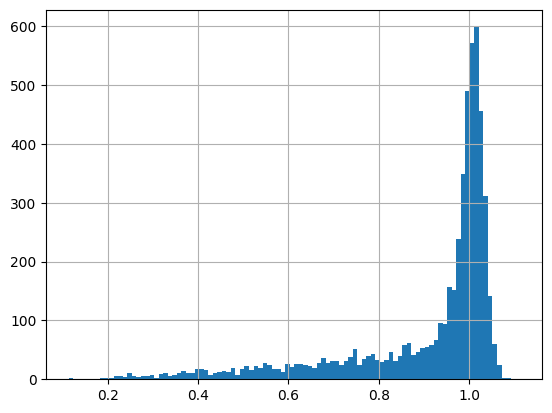

In [31]:
smf_filter.smf_30.hist(bins=100)

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

R2:   0.3443251494598465
MSE:  0.01550441239717911


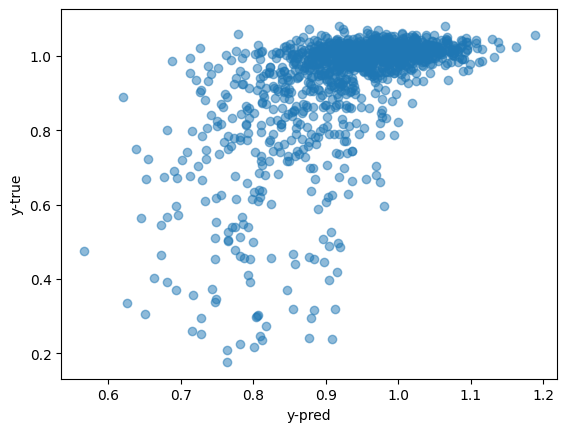

In [33]:
# How predictive are gene embeddings

A = smf_filter.merge(emb_full_pca, on='gene_id', how='inner').dropna()
X = A.iloc[:, 5:]
y = A['smf_30']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

lm = LinearRegression().fit(X_train, y_train)
print('R2:  ', lm.score(X_test, y_test))
print('MSE: ', mean_squared_error(y_test, lm.predict(X_test)))

plt.scatter(lm.predict(X_test), y_test, alpha=0.5)
plt.xlabel("y-pred")
plt.ylabel("y-true")
plt.show()